In [176]:
import json
import ast
import pandas as pd
import csv
import requests
import time
import traceback
from sqlalchemy import *
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import datetime
import instaconfig
from pytz import timezone

from geopy.distance import vincenty

from sklearn.neighbors.kde import KernelDensity
from sklearn.grid_search import GridSearchCV

instagram, database, search_tags = instaconfig.config()

engine = create_engine('mysql://%(user)s:%(pass)s@%(host)s' % database)
engine.execute('use instagram')

q = '''
    SELECT *
    FROM posts
    WHERE searched_tag IN 
    %s ;
    ''' % ("('" + "','".join(search_tags[:6]) + "')")  # :7

print q

df = pd.read_sql_query(q,con = engine)

%matplotlib inline
%pylab inline


    SELECT *
    FROM posts
    WHERE searched_tag IN 
    ('busk','busker','buskers','busking','streetmusic','streetmusician') ;
    
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [177]:
filter_coord = {
    'ul_lat' : 37.85,
    'ul_long' : -122.35,
    'lr_lat' : 37.7,
    'lr_long' : -122.6
    }

sf_df = df[(df.lat <= filter_coord['ul_lat']) & (df.longitude <= filter_coord['ul_long']) & (df.lat >= filter_coord['lr_lat']) & (df.longitude >= filter_coord['lr_long'])]

sf_df = sf_df.reset_index()

In [178]:
#sf_df = df

Xtrain = np.vstack((sf_df.longitude, sf_df.lat)).T
Xtrain *= np.pi/180

In [179]:
##############################################################################
# Compute DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=4e-5, 
            min_samples=4,
            metric='haversine'
           ).fit(Xtrain)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = list(db.labels_)

#labels = [int(label) for label in labels]

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

sf_df['cluster_label'] = pd.Series(labels)

Estimated number of clusters: 11


## Cluster geographic map

In [180]:
import folium
from IPython.display import IFrame

from geopy.geocoders import Nominatim

map_osm = folium.Map(location=[filter_coord['ul_lat'], filter_coord['ul_long']],
                    tiles='OpenStreetMap')

colors = [
    '#d73027',
    '#f46d43',
    '#fdae61',
    '#fee090',
    '#e0f3f8',
    '#abd9e9',
    '#74add1',
    '#4575b4'
]

labels = [int(label) for label in labels if label != -1]

color_labels = [colors[label % 7] for label in labels]

def make_circle(lat,lon,image_url,color_label): 
    map_osm.circle_marker(
        location = [lat,lon],
        radius=100,
        line_color=color_label,
        fill_color=color_label,
        popup = '<img src={url} width=200 height=200><br>'.format(
            url=image_url)
    )


sf_df_remove_outliers = sf_df[sf_df['cluster_label'] != -1]

pics = sf_df_remove_outliers[['lat','longitude','stand_res_url']].values
    
make_circle_vec = np.vectorize(make_circle)

make_circle_vec(pics[:,0],pics[:,1],pics[:,2],color_labels)

map_osm.create_map(path='osm.html')

IFrame('osm.html', 700, 700)

454


## Temporal Binning

In [181]:
df1 = sf_df[['created_time','cluster_label']]
df1['day_of_week'] = sf_df['created_time'].apply(lambda x: int(datetime.datetime.fromtimestamp(x).weekday()))
df1['day_of_month'] = sf_df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).day)
df1['hour_of_day'] = sf_df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).hour)
df1['month'] = sf_df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).month)
df1['year'] = sf_df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).year)

# Bin by some number of hours
time_bin_hours = 4
df1['hour_of_day'] = df1['hour_of_day'].apply(lambda x : x / time_bin_hours)

arrival_times = df1.groupby(['year','month','day_of_month','hour_of_day','day_of_week','cluster_label']).count().reset_index()
#(df1.groupby(['day_of_week','hour_of_day'])['created_time'].count()/249).plot()


#print arrival_times

/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

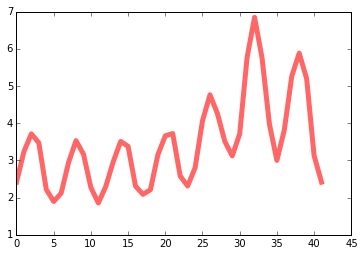

In [166]:
# Compute occupancy probability

from scipy.stats import beta

occupancy = (arrival_times.reset_index().groupby(['day_of_week','hour_of_day']).count()['year']).reset_index()

day_bins = np.zeros([7,24/time_bin_hours])

#for ii in xrange(0,7):
#    day_bins[ii] = np.zeros(24)

for ii in occupancy.index:
     day_bins[int(occupancy.loc[ii]['day_of_week'])][int(occupancy.loc[ii]['hour_of_day'])] = occupancy.loc[ii]['year']

l, u, md = zeros(7*24/time_bin_hours), zeros(7*24/time_bin_hours), zeros(7*24/time_bin_hours)

day_bins = day_bins.reshape([7*24/time_bin_hours])

for ii in xrange(0,7*24/time_bin_hours):
    
    a, b = day_bins[ii], 243-day_bins[ii]  #243
    
    alpha = .05

    l[ii] = beta.ppf(alpha / 2, a=a, b=b)
    u[ii] = beta.ppf(1 - alpha / 2, a=a, b=b)
    md[ii] = np.divide(a - 1, a + b - 2)

fig, ax = plt.subplots(1,1)
ax.plot(range(0,7*24/4), md, 'r-', lw=5, alpha=0.6,)
ax.plot(range(0,7*24/4), l, 'b--', lw=2, alpha=0.6,)
ax.plot(range(0,7*24/4), u, 'b--', lw=2, alpha=0.6,)

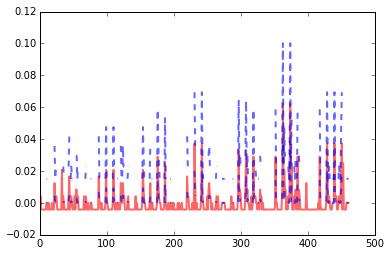

In [182]:
# Compute occupancy probability PER CLUSTER
from scipy.stats import beta

bins_in_day = 24/time_bin_hours
bins_in_week = 7*bins_in_day

occupancy = (arrival_times.reset_index().groupby(['day_of_week','hour_of_day','cluster_label']).count()['year']).reset_index()
day_bins = np.zeros([7,bins_in_day,n_clusters_])

# unpack occupancy
for ii in occupancy.index:
     day_bins[int(occupancy.loc[ii]['day_of_week'])][int(occupancy.loc[ii]['hour_of_day'])][int(occupancy.loc[ii]['cluster_label'])] = occupancy.loc[ii]['year']

l, u, md = zeros(bins_in_week*n_clusters_), zeros(bins_in_week*n_clusters_), zeros(bins_in_week*n_clusters_)
day_bins = day_bins.reshape([bins_in_week*n_clusters_])

# average
md = np.divide(day_bins, 243)

# MAP estimates per bin
for ii in xrange(0,bins_in_week*n_clusters_):
    a, b = day_bins[ii], 243-day_bins[ii]             # Default = 243
    alpha = .05                                       # leftover probability
    l[ii] = beta.ppf(alpha / 2.0, a=a, b=b)           # lower threshhold
    u[ii] = beta.ppf(1.0 - alpha / 2.0, a=a, b=b)     # upper threshhold
    md[ii] = np.divide(a - 1.0, a + b - 2.0)          # mode

fig, ax = plt.subplots(1,1)
ax.plot(range(0,bins_in_week*n_clusters_), md, 'r-', lw=2, alpha=0.6)
ax.plot(range(0,bins_in_week*n_clusters_), l, 'b--', lw=2, alpha=0.6)
ax.plot(range(0,bins_in_week*n_clusters_), u, 'b--', lw=2, alpha=0.6)

0.0 0.0


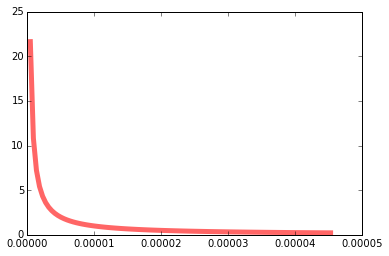

In [18]:
from scipy.stats import beta

a, b = 1e-5, 1e-3

x = np.linspace(beta.ppf(0.01, a, b),
                 beta.ppf(0.99, a, b), 100)

fig, ax = plt.subplots(1, 1)
ax.plot(x, beta.pdf(x, a, b),
        'r-', lw=5, alpha=0.6, label='beta pdf')

alpha = .05

l, u = beta.ppf(alpha / 2, a=a, b=b), beta.ppf(1 - alpha / 2, a=a, b=b)

print l, u

## MAP Estimate and Credible Intervals

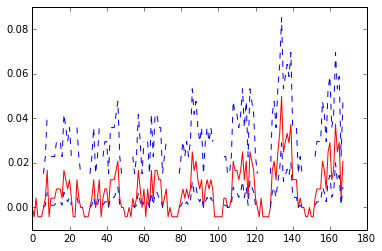

In [42]:
l, u, md = zeros(7*24), zeros(7*24), zeros(7*24)

day_bins = day_bins.reshape([7*24])

for ii in xrange(0,7*24):
    
    a, b = day_bins[ii], 243-day_bins[ii]

    #x = np.linspace(beta.ppf(0.01, a, b),
    #                 beta.ppf(0.99, a, b), 100)

    #fig, ax = plt.subplots(1, 1)
    #ax.plot(x, beta.pdf(x, a, b),
    #        'r-', lw=5, alpha=0.6, label='beta pdf')
    
    alpha = .05

    l[ii] = beta.ppf(alpha / 2, a=a, b=b)
    u[ii] = beta.ppf(1 - alpha / 2, a=a, b=b)
    md[ii] = np.divide(a - 1, a + b - 2)

fig, ax = plt.subplots(1,1)
ax.plot(range(0,7*24), md, 'r-')
ax.plot(range(0,7*24), l, 'b--')
ax.plot(range(0,7*24), u, 'b--')

/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


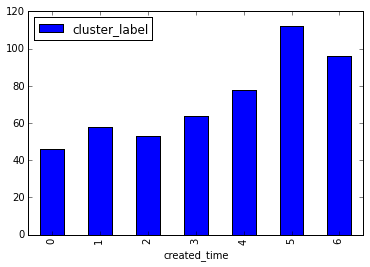

In [93]:
# Pictures binned by day of the week

df1 = sf_df[['created_time','cluster_label']]
df1['created_time'] = sf_df['created_time'].apply(lambda x: int(datetime.datetime.fromtimestamp(x).weekday()))
df1.groupby(['created_time']).count().plot(kind = 'bar')

/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


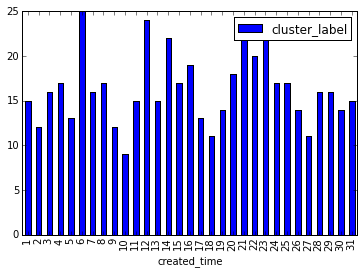

In [84]:
# Pictures binned by day of month
df1['created_time'] = sf_df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).day)
df1.groupby(['created_time']).count().plot(kind = 'bar')

/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


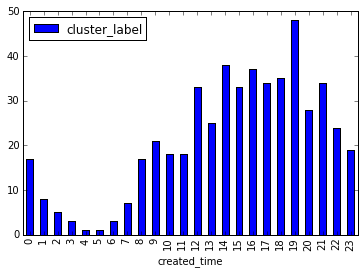

In [86]:
# Pictures binned by hour of day
df1['created_time'] = sf_df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).hour)
df1.groupby(['created_time']).count().plot(kind = 'bar')

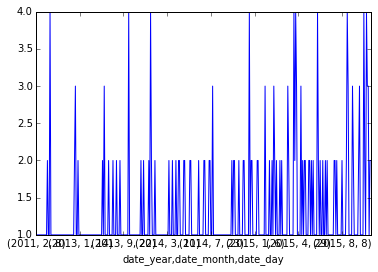

In [90]:
df1 = sf_df.groupby(['date_year','date_month','date_day']).count()['post_id'].plot()

## Compute Cluster Radius

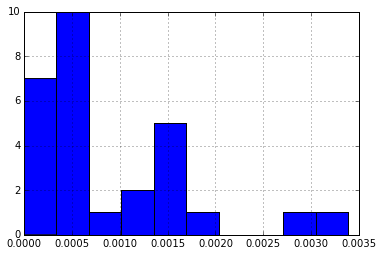

In [72]:
# Remove entries not belonging to cluster
cluster_df = sf_df[sf_df['cluster_label'] != -1]

cluster_centroids = cluster_df[['cluster_label','lat','longitude']].groupby(['cluster_label']).mean().reset_index()
cluster_point_centroids = pd.merge(left = cluster_df[['cluster_label','lat','longitude']], right = cluster_centroids, how = 'inner', on = 'cluster_label', suffixes = ('_point','_centroid')).reset_index()

# Distance measure
def dist(x1,x2,y1,y2):
    return np.sqrt(np.square(x1-y1)+np.square(x2-y2))

# Calculate distance of each point from centroid
cluster_point_centroids['distance_from_centroid'] = cluster_point_centroids.apply(lambda x: dist(x['lat_point'], x['longitude_point'], x['lat_centroid'], x['longitude_centroid']),axis = 1)

# Max over all distances from centroid
cluster_radius = cluster_point_centroids.groupby('cluster_label').max().reset_index()

cluster_radius['distance_from_centroid'].hist(bins = 10)

In [ ]:
import folium
from IPython.display import IFrame

from geopy.geocoders import Nominatim

map_osm = folium.Map(location=[filter_coord['ul_lat'], filter_coord['ul_long']],
                    tiles='OpenStreetMap')

colors = [
    '#d73027',
    '#f46d43',
    '#fdae61',
    '#fee090',
    '#e0f3f8',
    '#abd9e9',
    '#74add1',
    '#4575b4'
]

labels = [int(label) for label in labels if label != -1]

color_labels = [colors[label % 7] for label in labels]

def make_circle(lat,lon,image_url,color_label): 
    map_osm.circle_marker(
        location = [lat,lon],
        radius=100,
        line_color=color_label,
        fill_color=color_label,
        popup = '<img src={url} width=200 height=200><br>'.format(
            url=image_url)
    )


sf_df_remove_outliers = sf_df[sf_df['cluster_label'] != -1]

pics = sf_df_remove_outliers[['lat','longitude','stand_res_url']].values
    
make_circle_vec = np.vectorize(make_circle)

make_circle_vec(pics[:,0],pics[:,1],pics[:,2],color_labels)

map_osm.create_map(path='osm.html')

IFrame('osm.html', 700, 700)

In [74]:
cluster_radius

cluster_label  index  lat_point  longitude_point  lat_centroid  \
0               0     50  37.796228      -122.392928     37.795242   
1               1    210  37.789399      -122.404297     37.786156   
2               2    385  37.757591      -122.421093     37.757000   
3               3     18  37.770210      -122.446951     37.769925   
4               4    246  37.791335      -122.399380     37.789348   
5               5    318  37.775000      -122.418000     37.775000   
6               6    404  37.776241      -122.421326     37.776241   
7               7     83  37.808939      -122.410156     37.808761   
8               8    380  37.758629      -122.418411     37.758500   
9               9     90  37.769722      -122.476944     37.769722   
10             10    363  37.795035      -122.405983     37.794104   
11             11    270  37.809386      -122.414540     37.808450   
12             12    299  37.799049      -122.405737     37.797876   
13             13    219  37.765002      -122.419604     37.764891   
14             14    288  37.762520      -122.434692     37.761378   
15             15    339  37.752414      -122.418480     37.752167   
16             16    395  37.778416      -122.389751     37.778416   
17             17    372  37.779300      -122.419000     37.779227   
18             18    392  37.808428      -122.412844     37.808428   
19             19    249  37.784561      -122.433064     37.784332   
20             20     98  37.793329      -122.396383     37.792719   
21             21    369  37.764710      -122.421669     37.764472   
22             22    342  37.800696      -122.409841     37.800408   
23             23    278  37.772290      -122.460125     37.772290   
24             24    273  37.769521      -122.451520     37.769406   
25             25    326  37.763009      -122.420884     37.762814   
26             26    376  37.780204      -122.412849     37.779871   
27             27    399  37.780499      -122.416939     37.780011   

    longitude_centroid  distance_from_centroid  
0          -122.393684            1.452193e-03  
1          -122.407410            3.388646e-03  
2          -122.421136            5.949981e-04  
3          -122.447690            1.105386e-03  
4          -122.401667            3.030264e-03  
5          -122.418000            7.140866e-14  
6          -122.421326            1.421085e-14  
7          -122.410762            6.333379e-04  
8          -122.418880            6.075819e-04  
9          -122.476944            1.588822e-14  
10         -122.406453            1.562998e-03  
11         -122.415212            1.623305e-03  
12         -122.406816            1.945752e-03  
13         -122.420026            4.357940e-04  
14         -122.435005            1.415308e-03  
15         -122.418695            6.598509e-04  
16         -122.389751            0.000000e+00  
17         -122.419093            1.186966e-04  
18         -122.412844            7.105427e-15  
19         -122.433185            3.476651e-04  
20         -122.396715            1.608350e-03  
21         -122.421843            3.549484e-04  
22         -122.410133            4.105242e-04  
23         -122.460125            1.421085e-14  
24         -122.451926            4.222327e-04  
25         -122.421053            1.220581e-03  
26         -122.413446            6.842403e-04  
27         -122.417233            6.340726e-04

## Evaluate post density

In [187]:
df1.groupby(['cluster_label','day_of_week','day_of_month','hour_of_day','month','year']).count()

created_time
cluster_label day_of_week day_of_month hour_of_day month year              
-1            0           3            4           8     2015             1
                          13           4           10    2014             1
                          14           3           9     2015             1
                          18           3           5     2015             1
                          20           4           7     2015             1
                          23           0           3     2015             1
              1           10           3           3     2015             1
                          12           2           11    2013             1
                          20           0           5     2014             1
              2           4            3           3     2015             1
                          18           2           7     2012             1
                          24           1           12    2014             1
              3           2            0           7     2015             1
                          4            3           9     2014             1
                          14           5           2     2013             1
                          18           4           9     2014             1
                          23           3           4     2015             1
                                       4           4     2015             1
                          31           4           7     2014             1
              4           1            5           11    2013             1
                          4            4           1     2013             1
                          5            3           9     2014             1
                          13           0           2     2015             1
                          14           2           2     2014             1
                                       4           8     2015             1
                          15           4           11    2013             1
                          16           5           5     2014             1
                          19           3           6     2015             2
                          20           2           6     2014             1
                                       5           4     2012             1
...                                                                     ...
 8            3           31           0           7     2014             1
              4           2            4           5     2014             1
                          12           5           10    2012             1
                          28           4           8     2015             1
                          31           0           7     2015             1
              5           5            3           9     2015             1
                          9            4           3     2013             1
                                                   7     2011             1
                          21           3           6     2014             1
                          22           4           8     2015             1
              6           7            4           9     2014             1
                          8            5           3     2015             1
                          24           3           6     2012             1
 9            2           19           5           8     2015             1
              4           21           0           8     2015             1
              5           4            3           4     2015             1
              6           7            4           6     2015             1
                          8            5           3     2015             1
                          17           1           5     2015             1
                          22           3           2     2015             1
 10           1           8        

In [121]:
dt = datetime.datetime.now() - datetime.datetime.fromtimestamp(1291952805)

dt.days / 7

249

In [41]:
print datetime.datetime.now().weekday()

print (datetime.datetime.now() - datetime.datetime.fromtimestamp(df['created_time'].min())).days / 7

1
243


In [ ]:
from scipy.optimize import leastsq

def fitfunc(p, x) :
    return (p[0] * (1 - p[1] * np.sin(2 * np.pi / (24 * 3600) * (x + p[2]))))

def residuals(p, y, x) :
    return y - fitfunc(p, x)

def fit(tsdf) :
    tsgb = tsdf.groupby(tsdf.timeofday).mean()
    p0 = np.array([tsgb[“conns”].mean(), 1.0, 0.0])
    plsq, suc = leastsq(residuals, p0, args=(tsgb[“conns”], np.array(tsgb.index)))
    return plsq

In [ ]:
## Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

num_clusters = 12

agc = AgglomerativeClustering(n_clusters = num_clusters, affinity = 'Euclidean', linkage = 'complete').fit(Xtrain)

labels = agc.labels_

sf_df['cluster_label'] = pd.Series(labels)

In [ ]:
vincenty()

In [168]:
arrival_times

year  month  day_of_month  hour_of_day  day_of_week  cluster_label  \
0      2011      1            20            5            3             22   
1      2011      1            29            0            5            107   
2      2011      1            29            5            5             26   
3      2011      2             3            2            3             -1   
4      2011      2             8            2            1            139   
5      2011      2            13            5            6            138   
6      2011      2            13            5            6            285   
7      2011      2            18            1            4             -1   
8      2011      2            19            5            5             96   
9      2011      2            23            4            2           1268   
10     2011      3             9            4            2            107   
11     2011      3            10            4            3            364   
12     2011      3            20            1            6             -1   
13     2011      3            21            1            0             -1   
14     2011      3            24            0            3           1076   
15     2011      3            25            4            4             -1   
16     2011      3            29            1            1             30   
17     2011      4             2            5            5            148   
18     2011      4             8            0            4             -1   
19     2011      4             9            3            5             -1   
20     2011      4            10            3            6             -1   
21     2011      4            14            3            3             -1   
22     2011      4            16            1            5             39   
23     2011      4            16            1            5            568   
24     2011      4            23            3            5            364   
25     2011      4            24            4            6              3   
26     2011      4            26            5            1             22   
27     2011      4            30            2            5             -1   
28     2011      4            30            2            5             79   
29     2011      5             3            0            1             26   
...     ...    ...           ...          ...          ...            ...   
34792  2015      9            20            4            6            786   
34793  2015      9            20            4            6            852   
34794  2015      9            20            4            6           1025   
34795  2015      9            20            4            6           1364   
34796  2015      9            20            5            6             -1   
34797  2015      9            20            5            6              1   
34798  2015      9            20            5            6              3   
34799  2015      9            20            5            6              6   
34800  2015      9            20            5            6              7   
34801  2015      9            20            5            6             26   
34802  2015      9            20            5            6             30   
34803  2015      9            20            5            6             47   
34804  2015      9            20            5            6            107   
34805  2015      9            20            5            6            347   
34806  2015      9            20            5            6            483   
34807  2015      9            20            5            6            718   
34808  2015      9            20            5            6           1156   
34809  2015      9            20            5            6           1255   
34810  2015      9            20            5            6           1268   
34811  2015      9            21            0            0             -1   
348